In [1]:
# Imports...

import getpass
import h5py
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.markers as markers
from matplotlib.colors import LogNorm
import os
import json
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler

/afs/cern.ch/user/t/tkrzyzek/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Get permission to access EOS (Insert your NICE password)

os.system("echo %s | kinit" % getpass.getpass())

········


0

In [3]:
PDs  = {1: 'BTagCSV',
        2: 'BTagMu',
        3: 'Charmonium',
        4: 'DisplacedJet',
        5: 'DoubleEG',
        6: 'DoubleMuon',
        7: 'DoubleMuonLowMass',
        8: 'FSQJets',
        9: 'HighMultiplicityEOF',
        10: 'HTMHT',
        11: 'JetHT',
        12: 'MET',
        13: 'MinimumBias',
        14: 'MuonEG',
        15: 'MuOnia',
        16: 'NoBPTX',
        17: 'SingleElectron',
        18: 'SingleMuon',
        19: 'SinglePhoton',
        20: 'Tau',
        21: 'ZeroBias'}

# Select PD
nPD = 11

In [4]:
data_directory = "/eos/cms/store/user/fsiroky/consistentlumih5/"
label_file = "/afs/cern.ch/user/t/tkrzyzek/Documents/Data-Certification/JetHT.json"

In [5]:
def get_file_list(directory, pds, npd, typeof, extension):
    files = []
    parts = ["C", "D", "E", "F", "G", "H"]
    for p in parts:
        files.append("%s%s_%s_%s%s" % (directory, pds[npd], p, typeof, extension))
    return files

files = get_file_list(data_directory, PDs, nPD, "background", ".h5")
files = files + get_file_list(data_directory, PDs, nPD, "signal", ".h5")

In [6]:
# Load good and bad jets

def get_data(files):
    readout = np.empty([0,2813])
    
    for file in files:
        jet = file.split("/")[-1][:-3]
        print("Reading: %s" % jet)
        try:
            h5file = h5py.File(file, "r")
            readout = np.concatenate((readout, h5file[jet][:]), axis=0)
        except OSError as error:
            print("This Primary Dataset doesn't have %s. %s" % (jet, error))
            continue

    return readout

data = pd.DataFrame(get_data(files))

Reading: JetHT_C_background
Reading: JetHT_D_background
Reading: JetHT_E_background
Reading: JetHT_F_background
Reading: JetHT_G_background
Reading: JetHT_H_background
Reading: JetHT_C_signal
Reading: JetHT_D_signal
Reading: JetHT_E_signal
Reading: JetHT_F_signal
Reading: JetHT_G_signal
Reading: JetHT_H_signal


In [7]:
data["run"] = data[2807].astype(int)
data["lumi"] = data[2808].astype(int)
data["inst_lumi"] = data[2809].astype(float)

In [8]:
# Drop unnecessary meta data
data.drop([2807, 2808, 2809, 2810, 2811, 2812], axis=1, inplace=True)

# Sort by runID and then by lumiID
data = data.sort_values(["run", "lumi"], ascending=[True,True])

# Reset index
data = data.reset_index(drop=True)

In [9]:
# Apply labels
output_json = json.load(open(label_file))

def json_checker(json_file, orig_runid, orig_lumid):
    try:
        for i in json_file[str(int(orig_runid))]:
            if orig_lumid >= i[0] and orig_lumid <= i[1]:
                return 0
    except KeyError:
        pass
    return 1

def add_flags(sample):
    return json_checker(output_json, sample["run"], sample["lumi"])

data["label"] = data.apply(add_flags, axis=1)

In [10]:
# Normalize the data
normalized_data = data.copy()
scaler = StandardScaler()
normalized_data.iloc[:, 0:2806] = scaler.fit_transform(normalized_data.iloc[:, 0:2806].values)

In [11]:
legend = [{"name": 'pf_jets', "start": 0, "end": 776},
          {"name": 'cal_jet_mets', "start": 777, "end": 944},
          {"name": 'pho', "start": 945, "end": 1280},
          {"name": 'muons', "start": 1281, "end": 1784},
          {"name": 'pf_jets2', "start": 1785, "end": 1889},
          {"name": 'pf_mets', "start": 1890, "end": 1917},
          {"name": 'nvtx', "start": 1918, "end": 1924},
          {"name": 'cal_jet_mets2', "start": 1925},
          {"name": 'sc', "start": 2037, "end": 2127},
          {"name": 'cc', "start": 2128, "end": 2169},
          {"name": 'pho2', "start": 2170, "end": 2365},
          {"name": 'muons2', "start": 2366, "end": 2491},
          {"name": 'ebs', "start": 2492, "end": 2701},
          {"name": 'hbhef', "start": 2702, "end": 2764},
          {"name": 'presh', "start": 2765, "end": 2806}]

In [12]:
# Feature description
feature_names = ['qPFJetPt', 'qPFJetEta', 'qPFJetPhi', 'qPFJet0Pt', 'qPFJet1Pt', 'qPFJet2Pt', 'qPFJet3Pt', 'qPFJet4Pt', 'qPFJet5Pt', 'qPFJet0Eta', 'qPFJet1Eta', 'qPFJet2Eta', 'qPFJet3Eta', 'qPFJet4Eta', 'qPFJet5Eta', 'qPFJet0Phi', 'qPFJet1Phi', 'qPFJet2Phi', 'qPFJet3Phi', 'qPFJet4Phi', 'qPFJet5Phi', 'qPFJet4CHS0Pt', 'qPFJet4CHS1Pt', 'qPFJet4CHS2Pt', 'qPFJet4CHS3Pt', 'qPFJet4CHS4Pt', 'qPFJet4CHS5Pt', 'qPFJet4CHS0Eta', 'qPFJet4CHS1Eta', 'qPFJet4CHS2Eta', 'qPFJet4CHS3Eta', 'qPFJet4CHS4Eta', 'qPFJet4CHS5Eta', 'qPFJet4CHS0Phi', 'qPFJet4CHS1Phi', 'qPFJet4CHS2Phi', 'qPFJet4CHS3Phi', 'qPFJet4CHS4Phi', 'qPFJet4CHS5Phi', 'qPFJet8CHS0Pt', 'qPFJet8CHS1Pt', 'qPFJet8CHS2Pt', 'qPFJet8CHS3Pt', 'qPFJet8CHS4Pt', 'qPFJet8CHS5Pt', 'qPFJet8CHS0Eta', 'qPFJet8CHS1Eta', 'qPFJet8CHS2Eta', 'qPFJet8CHS3Eta', 'qPFJet8CHS4Eta', 'qPFJet8CHS5Eta', 'qPFJet8CHS0Phi', 'qPFJet8CHS1Phi', 'qPFJet8CHS2Phi', 'qPFJet8CHS3Phi', 'qPFJet8CHS4Phi', 'qPFJet8CHS5Phi', 'qPFJetEI0Pt', 'qPFJetEI1Pt', 'qPFJetEI2Pt', 'qPFJetEI3Pt', 'qPFJetEI4Pt', 'qPFJetEI5Pt', 'qPFJetEI0Eta', 'qPFJetEI1Eta', 'qPFJetEI2Eta', 'qPFJetEI3Eta', 'qPFJetEI4Eta', 'qPFJetEI5Eta', 'qPFJetEI0Phi', 'qPFJetEI1Phi', 'qPFJetEI2Phi', 'qPFJetEI3Phi', 'qPFJetEI4Phi', 'qPFJetEI5Phi', 'qPFJet8CHSSD0Pt', 'qPFJet8CHSSD1Pt', 'qPFJet8CHSSD2Pt', 'qPFJet8CHSSD3Pt', 'qPFJet8CHSSD4Pt', 'qPFJet8CHSSD5Pt', 'qPFJet8CHSSD0Eta', 'qPFJet8CHSSD1Eta', 'qPFJet8CHSSD2Eta', 'qPFJet8CHSSD3Eta', 'qPFJet8CHSSD4Eta', 'qPFJet8CHSSD5Eta', 'qPFJet8CHSSD0Phi', 'qPFJet8CHSSD1Phi', 'qPFJet8CHSSD2Phi', 'qPFJet8CHSSD3Phi', 'qPFJet8CHSSD4Phi', 'qPFJet8CHSSD5Phi', 'qPFJetTopCHS0Pt', 'qPFJetTopCHS1Pt', 'qPFJetTopCHS2Pt', 'qPFJetTopCHS3Pt', 'qPFJetTopCHS4Pt', 'qPFJetTopCHS5Pt', 'qPFJetTopCHS0Eta', 'qPFJetTopCHS1Eta', 'qPFJetTopCHS2Eta', 'qPFJetTopCHS3Eta', 'qPFJetTopCHS4Eta', 'qPFJetTopCHS5Eta', 'qPFJetTopCHS0Phi', 'qPFJetTopCHS1Phi', 'qPFJetTopCHS2Phi', 'qPFJetTopCHS3Phi', 'qPFJetTopCHS4Phi', 'qPFJetTopCHS5Phi', 'qCalJet0Pt', 'qCalJet1Pt', 'qCalJet2Pt', 'qCalJet3Pt', 'qCalJet4Pt', 'qCalJet5Pt', 'qCalJet0Eta', 'qCalJet1Eta', 'qCalJet2Eta', 'qCalJet3Eta', 'qCalJet4Eta', 'qCalJet5Eta', 'qCalJet0Phi', 'qCalJet1Phi', 'qCalJet2Phi', 'qCalJet3Phi', 'qCalJet4Phi', 'qCalJet5Phi', 'qCalJet0En', 'qCalJet1En', 'qCalJet2En', 'qCalJet3En', 'qCalJet4En', 'qCalJet5En', 'qPho0Pt', 'qPho1Pt', 'qPho2Pt', 'qPho3Pt', 'qPho4Pt', 'qPho5Pt', 'qPho0Eta', 'qPho1Eta', 'qPho2Eta', 'qPho3Eta', 'qPho4Eta', 'qPho5Eta', 'qPho0Phi', 'qPho1Phi', 'qPho2Phi', 'qPho3Phi', 'qPho4Phi', 'qPho5Phi', 'qPho0En', 'qPho1En', 'qPho2En', 'qPho3En', 'qPho4En', 'qPho5En', 'qgedPho0Pt', 'qgedPho1Pt', 'qgedPho2Pt', 'qgedPho3Pt', 'qgedPho4Pt', 'qgedPho5Pt', 'qgedPho0Eta', 'qgedPho1Eta', 'qgedPho2Eta', 'qgedPho3Eta', 'qgedPho4Eta', 'qgedPho5Eta', 'qgedPho0Phi', 'qgedPho1Phi', 'qgedPho2Phi', 'qgedPho3Phi', 'qgedPho4Phi', 'qgedPho5Phi', 'qgedPho0En', 'qgedPho1En', 'qgedPho2En', 'qgedPho3En', 'qgedPho4En', 'qgedPho5En', 'qMu0Pt', 'qMu1Pt', 'qMu2Pt', 'qMu3Pt', 'qMu4Pt', 'qMu5Pt', 'qMu0Eta', 'qMu1Eta', 'qMu2Eta', 'qMu3Eta', 'qMu4Eta', 'qMu5Eta', 'qMu0Phi', 'qMu1Phi', 'qMu2Phi', 'qMu3Phi', 'qMu4Phi', 'qMu5Phi', 'qMu0En', 'qMu1En', 'qMu2En', 'qMu3En', 'qMu4En', 'qMu5En', 'qMuCosm0Pt', 'qMuCosm1Pt', 'qMuCosm2Pt', 'qMuCosm3Pt', 'qMuCosm4Pt', 'qMuCosm5Pt', 'qMuCosm0Eta', 'qMuCosm1Eta', 'qMuCosm2Eta', 'qMuCosm3Eta', 'qMuCosm4Eta', 'qMuCosm5Eta', 'qMuCosm0Phi', 'qMuCosm1Phi', 'qMuCosm2Phi', 'qMuCosm3Phi', 'qMuCosm4Phi', 'qMuCosm5Phi', 'qMuCosm0En', 'qMuCosm1En', 'qMuCosm2En', 'qMuCosm3En', 'qMuCosm4En', 'qMuCosm5En', 'qMuCosmLeg0Pt', 'qMuCosmLeg1Pt', 'qMuCosmLeg2Pt', 'qMuCosmLeg3Pt', 'qMuCosmLeg4Pt', 'qMuCosmLeg5Pt', 'qMuCosmLeg0Eta', 'qMuCosmLeg1Eta', 'qMuCosmLeg2Eta', 'qMuCosmLeg3Eta', 'qMuCosmLeg4Eta', 'qMuCosmLeg5Eta', 'qMuCosmLeg0Phi', 'qMuCosmLeg1Phi', 'qMuCosmLeg2Phi', 'qMuCosmLeg3Phi', 'qMuCosmLeg4Phi', 'qMuCosmLeg5Phi', 'qMuCosmLeg0En', 'qMuCosmLeg1En', 'qMuCosmLeg2En', 'qMuCosmLeg3En', 'qMuCosmLeg4En', 'qMuCosmLeg5En', 'qPFJet4CHSPt', 'qPFJet4CHSEta', 'qPFJet4CHSPhi', 'qPFJet8CHSPt', 'qPFJet8CHSEta', 'qPFJet8CHSPhi', 'qPFJetEIPt', 'qPFJetEIEta', 'qPFJetEIPhi', 'qPFJet8CHSSDPt', 'qPFJet8CHSSDEta', 'qPFJet8CHSSDPhi', 'qPFJetTopCHSPt', 'qPFJetTopCHSEta', 'qPFJetTopCHSPhi', 'qPFChMetPt', 'qPFChMetPhi', 'qPFMetPt', 'qPFMetPhi', 'qNVtx', 'qCalJetPt', 'qCalJetEta', 'qCalJetPhi', 'qCalJetEn', 'qCalMETPt', 'qCalMETPhi', 'qCalMETEn', 'qCalMETBEPt', 'qCalMETBEPhi', 'qCalMETBEEn', 'qCalMETBEFOPt', 'qCalMETBEFOPhi', 'qCalMETBEFOEn', 'qCalMETMPt', 'qCalMETMPhi', 'qCalMETMEn', 'qSCEn', 'qSCEta', 'qSCPhi', 'qSCEtaWidth', 'qSCPhiWidth', 'qSCEnhfEM', 'qSCEtahfEM', 'qSCPhihfEM', 'qSCEn5x5', 'qSCEta5x5', 'qSCPhi5x5', 'qSCEtaWidth5x5', 'qSCPhiWidth5x5', 'qCCEn', 'qCCEta', 'qCCPhi', 'qCCEn5x5', 'qCCEta5x5', 'qCCPhi5x5', 'qPhoPt', 'qPhoEta', 'qPhoPhi', 'qPhoEn_', 'qPhoe1x5_', 'qPhoe2x5_', 'qPhoe3x3_', 'qPhoe5x5_', 'qPhomaxenxtal_', 'qPhosigmaeta_', 'qPhosigmaIeta_', 'qPhor1x5_', 'qPhor2x5_', 'qPhor9_', 'qgedPhoPt', 'qgedPhoEta', 'qgedPhoPhi', 'qgedPhoEn_', 'qgedPhoe1x5_', 'qgedPhoe2x5_', 'qgedPhoe3x3_', 'qgedPhoe5x5_', 'qgedPhomaxenxtal_', 'qgedPhosigmaeta_', 'qgedPhosigmaIeta_', 'qgedPhor1x5_', 'qgedPhor2x5_', 'qgedPhor9_', 'qMuPt', 'qMuEta', 'qMuPhi', 'qMuEn_', 'qMuCh_', 'qMuChi2_', 'qMuCosmPt', 'qMuCosmEta', 'qMuCosmPhi', 'qMuCosmEn_', 'qMuCosmCh_', 'qMuCosmChi2_', 'qMuCosmLegPt', 'qMuCosmLegEta', 'qMuCosmLegPhi', 'qMuCosmLegEn_', 'qMuCosmLegCh_', 'qMuCosmLegChi2_', 'qSigmaIEta', 'qSigmaIPhi', 'qr9', 'qHadOEm', 'qdrSumPt', 'qdrSumEt', 'qeSCOP', 'qecEn', 'qUNSigmaIEta', 'qUNSigmaIPhi', 'qUNr9', 'qUNHadOEm', 'qUNdrSumPt', 'qUNdrSumEt', 'qUNeSCOP', 'qUNecEn', 'qEBenergy', 'qEBtime', 'qEBchi2', 'qEBiEta', 'qEBiPhi', 'qEEenergy', 'qEEtime', 'qEEchi2', 'qEEix', 'qEEiy', 'qESenergy', 'qEStime', 'qESix', 'qESiy', 'qHBHEenergy', 'qHBHEtime', 'qHBHEauxe', 'qHBHEieta', 'qHBHEiphi', 'qHFenergy', 'qHFtime', 'qHFieta', 'qHFiphi', 'qPreShEn', 'qPreShEta', 'qPreShPhi', 'qPreShYEn', 'qPreShYEta', 'qPreShYPhi']

In [13]:
# Take the last 90% to compare with AE output
split = round(0.1*len(data))
data = data.iloc[split:]
normalized_data = normalized_data.iloc[split:]

## Original data (last 90% of it, the same as AE test set)

In [14]:
data.shape

(147316, 2811)

In [15]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,2801,2802,2803,2804,2805,2806,run,lumi,inst_lumi,label
count,147316.000000,147316.000000,147316.000000,147316.000000,147316.000000,147316.000000,147316.000000,147316.000000,147316.000000,147316.000000,...,147316.000000,147316.000000,147316.000000,147316.0,147316.000000,147316.000000,147316.000000,147316.000000,147316.000000,147316.000000
mean,16.667922,39.260520,5.000034,6.689127,8.942856,12.791651,1308.971378,-0.016430,2.724758,-5.078014,...,1.668824,-3.141295,-1.211820,0.0,1.211933,3.141310,279619.107938,712.563503,0.172573,0.012368
std,1.220283,3.544112,0.000109,0.387626,0.824798,1.798535,1001.809352,0.025297,0.093037,0.055294,...,0.034780,0.000743,0.100969,0.0,0.059929,0.000726,2522.689120,611.739798,0.052603,0.110522
min,11.433883,11.645899,5.000000,5.960115,7.439107,10.749500,296.778442,-1.034913,1.852814,-9.193869,...,1.387164,-3.141593,-1.851747,0.0,0.382779,3.049975,276282.000000,1.000000,0.001000,0.000000
25%,16.255982,37.463640,5.000008,6.371743,8.266780,11.645051,1032.599731,-0.023054,2.668875,-5.086105,...,1.663645,-3.141527,-1.239442,0.0,1.197412,3.141254,277076.000000,226.000000,0.135000,0.000000
50%,16.489694,38.846563,5.000019,6.626444,8.802109,12.450546,1169.255188,-0.009353,2.734117,-5.076467,...,1.673971,-3.141429,-1.225447,0.0,1.215612,3.141434,279654.000000,536.500000,0.169000,0.000000
75%,16.823512,40.948659,5.000039,6.947635,9.487178,13.554919,1372.068695,-0.004729,2.789105,-5.067401,...,1.682646,-3.141245,-1.208806,0.0,1.231662,3.141527,281976.000000,1046.000000,0.208000,0.000000
max,47.489899,169.724380,5.010633,8.098554,12.098029,48.596684,34764.457031,0.129763,2.978654,-4.570033,...,1.891839,-3.094292,-0.340612,0.0,1.880385,3.141593,284044.000000,3484.000000,0.341000,1.000000


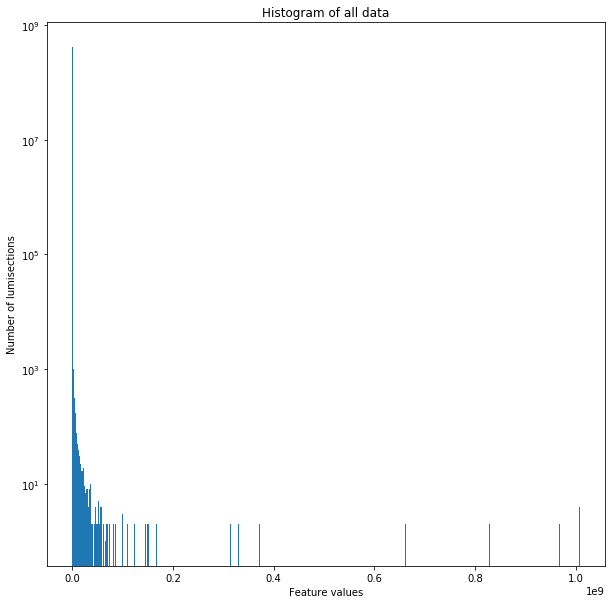

In [16]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.hist(data.iloc[:, :2807].values.reshape(-1), bins=1000)
plt.ylabel("Number of lumisections")
plt.xlabel("Feature values")
# plt.xscale('log')
plt.yscale('log')
plt.title("Histogram of all data")
plt.show()

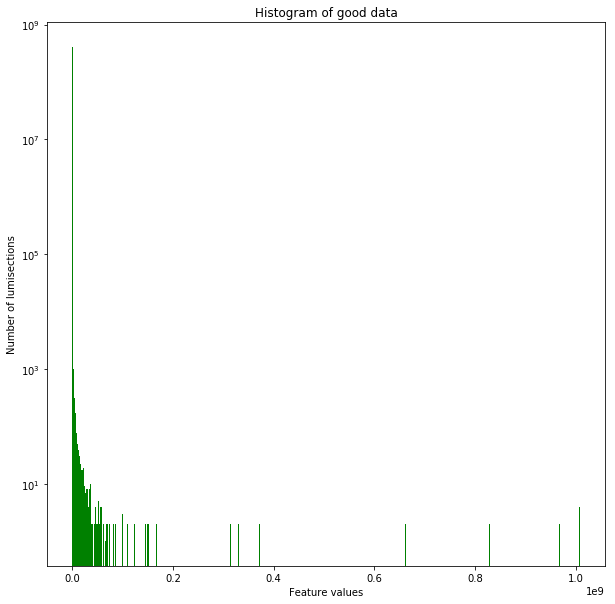

In [17]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.hist(data[data['label'] == 0].iloc[:, :2807].values.reshape(-1), bins=1000, color='g')
plt.ylabel("Number of lumisections")
plt.xlabel("Feature values")
# plt.xscale('log')
plt.yscale('log')
plt.title("Histogram of good data")
plt.show()

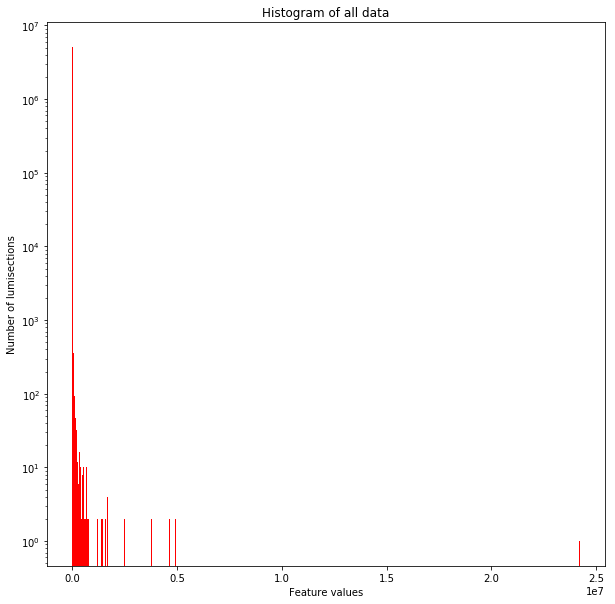

In [18]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.hist(data[data['label'] == 1].iloc[:, :2807].values.reshape(-1), bins=1000, color='r')
plt.ylabel("Number of lumisections")
plt.xlabel("Feature values")
# plt.xscale('log')
plt.yscale('log')
plt.title("Histogram of all data")
plt.show()

## Data normalized using StandardScaler (zero mean, unit variance)

In [19]:
normalized_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,2801,2802,2803,2804,2805,2806,run,lumi,inst_lumi,label
count,147316.000000,147316.000000,147316.000000,147316.000000,147316.000000,147316.000000,147316.000000,147316.000000,147316.000000,147316.000000,...,147316.000000,147316.000000,147316.000000,147316.0,147316.000000,147316.000000,147316.000000,147316.000000,147316.000000,147316.000000
mean,-0.004295,-0.028093,0.002324,0.046443,0.046227,0.036869,-0.001282,-0.034603,0.016301,0.000451,...,-0.050647,0.002033,0.037206,0.0,-0.039631,3.141310,279619.107938,712.563503,0.172573,0.012368
std,1.015608,1.008142,1.042756,1.014847,1.015834,1.034619,1.020910,1.033916,0.995454,1.007834,...,1.032354,1.036374,1.039849,0.0,1.027852,0.000726,2522.689120,611.739798,0.052603,0.110522
min,-4.360441,-7.883221,-0.319100,-1.862188,-1.805813,-1.137892,-1.032774,-41.660613,-9.313076,-75.018311,...,-8.410955,-0.412680,-6.553247,0.0,-14.260653,3.049975,276282.000000,1.000000,0.001000,0.000000
25%,-0.347141,-0.539225,-0.241784,-0.784502,-0.786439,-0.622721,-0.282924,-0.305336,-0.581614,-0.147010,...,-0.204377,-0.320545,-0.247267,0.0,-0.288681,3.141254,277076.000000,226.000000,0.135000,0.000000
50%,-0.152630,-0.145845,-0.137179,-0.117668,-0.127120,-0.159354,-0.143663,0.254659,0.116442,0.028651,...,0.102129,-0.184171,-0.103131,0.0,0.023475,3.141434,279654.000000,536.500000,0.169000,0.000000
75%,0.125198,0.452107,0.053837,0.723246,0.716622,0.475944,0.063018,0.443630,0.704793,0.193899,...,0.359631,0.071945,0.068242,0.0,0.298743,3.141527,281976.000000,1046.000000,0.208000,0.000000
max,25.647983,37.083054,101.101622,3.736478,3.932185,20.633958,34.092084,5.940377,2.732867,9.259310,...,6.568929,65.576141,9.009557,0.0,11.425151,3.141593,284044.000000,3484.000000,0.341000,1.000000


In [20]:
normalized_data.shape

(147316, 2811)

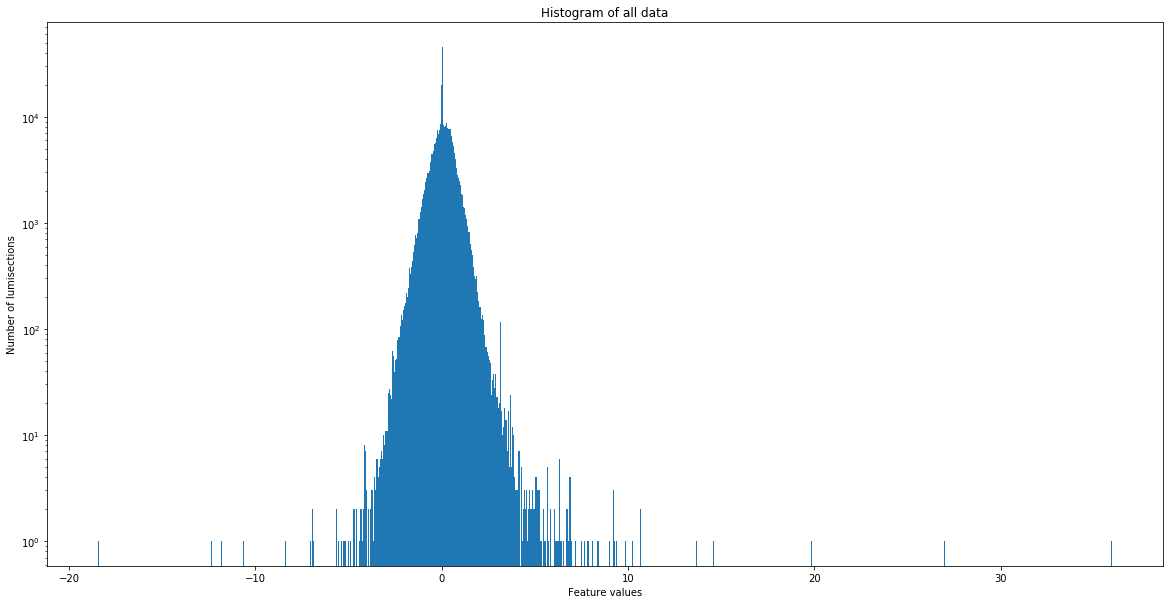

In [21]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.hist(normalized_data.iloc[:100, :2807].values.reshape(-1), bins=1000)
plt.ylabel("Number of lumisections")
plt.xlabel("Feature values")
# plt.xscale('log')
plt.yscale('log')
plt.title("Histogram of all data")
plt.show()

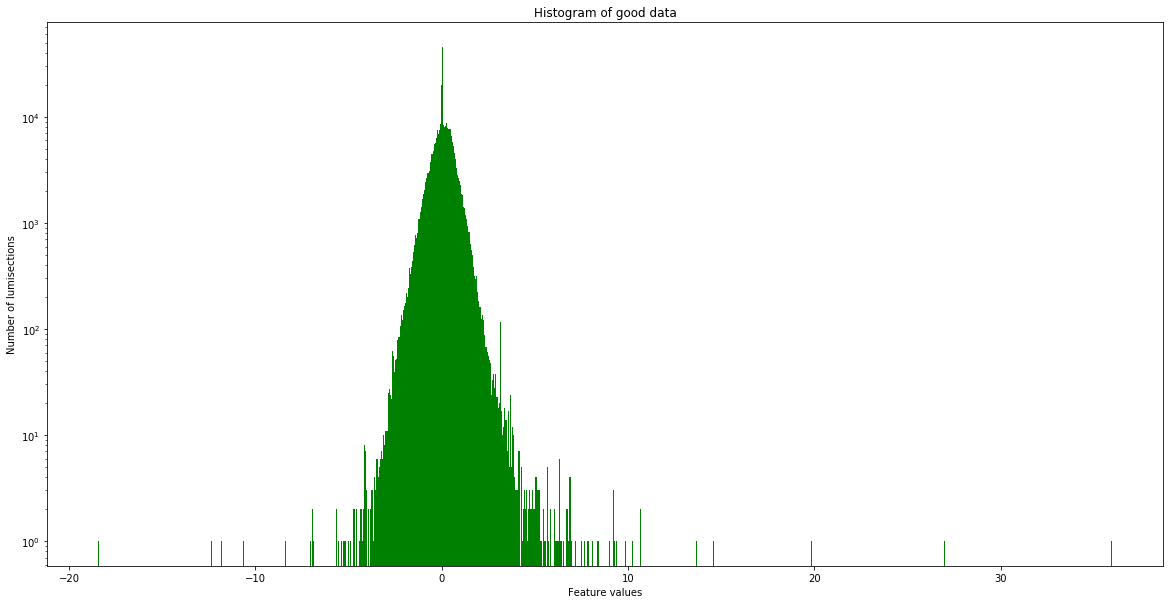

In [22]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.hist(normalized_data[normalized_data.label == 0].iloc[:100, :2807].values.reshape(-1), 
         bins=1000, color='g')
plt.ylabel("Number of lumisections")
plt.xlabel("Feature values")
# plt.xscale('log')
plt.yscale('log')
plt.title("Histogram of good data")
plt.show()

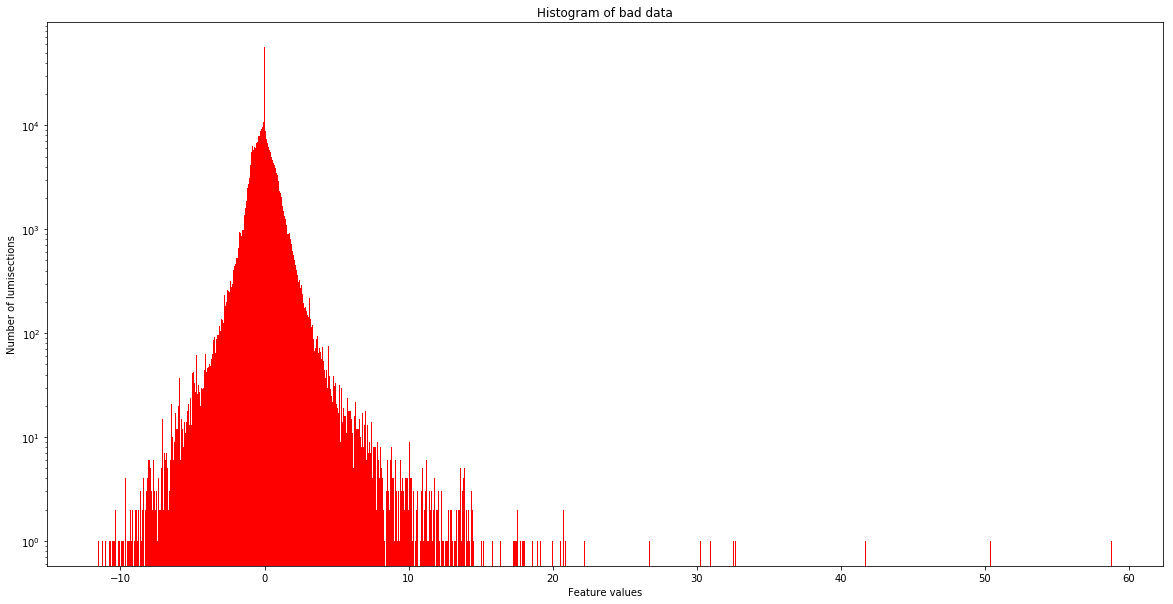

In [23]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.hist(normalized_data[normalized_data.label == 1].iloc[:100, :2807].values.reshape(-1), 
         bins=1000, color='r')
plt.ylabel("Number of lumisections")
plt.xlabel("Feature values")
# plt.xscale('log')
plt.yscale('log')
plt.title("Histogram of bad data")
plt.show()

In [24]:
files_dir = "/eos/user/t/tkrzyzek/autoencoder/standard/"
ae_pred = pickle.load(open(files_dir + "ae_pred.p", "rb"))
y = pickle.load(open(files_dir + "y.p", "rb"))

In [25]:
ae_pred.shape

(147316, 2806)

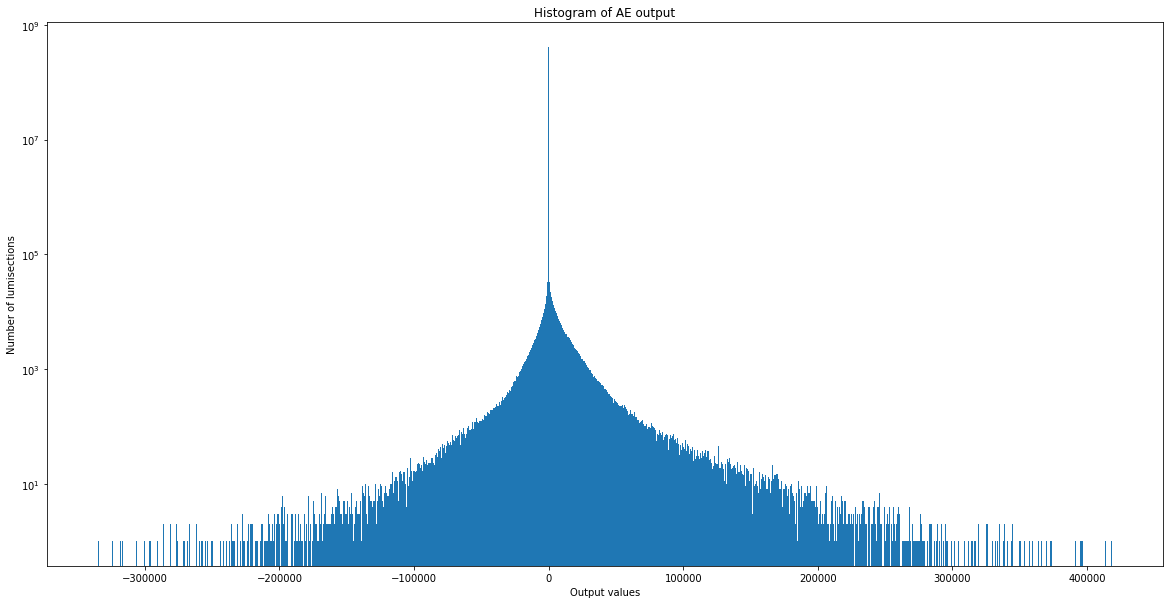

In [26]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.hist(ae_pred[:, :2807].reshape(-1), bins=1000)
plt.ylabel("Number of lumisections")
plt.xlabel("Output values")
# plt.xscale('log')
plt.yscale('log')
plt.title("Histogram of AE output")
plt.show()

## Feature values vs output values, two-dimensional histogram

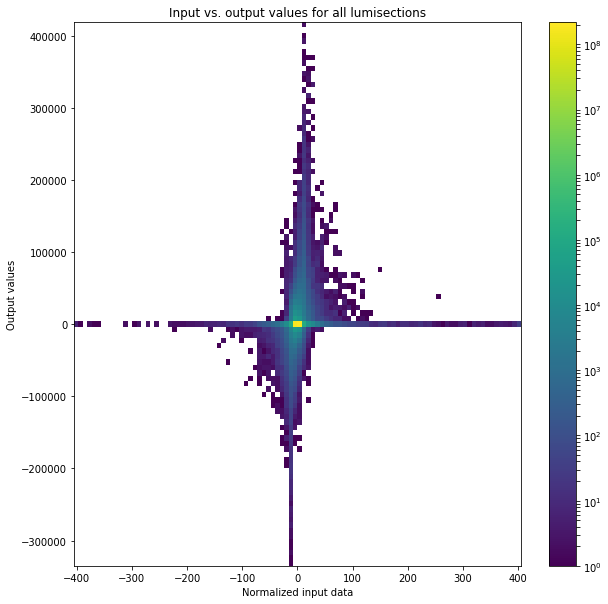

In [27]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.hist2d(normalized_data.iloc[:, :2806].values.reshape(-1), 
           ae_pred.reshape(-1),
          bins=100, norm=LogNorm())
plt.colorbar()
plt.xlabel("Normalized input data")
plt.ylabel("Output values")
plt.title("Input vs. output values for all lumisections")
plt.show()

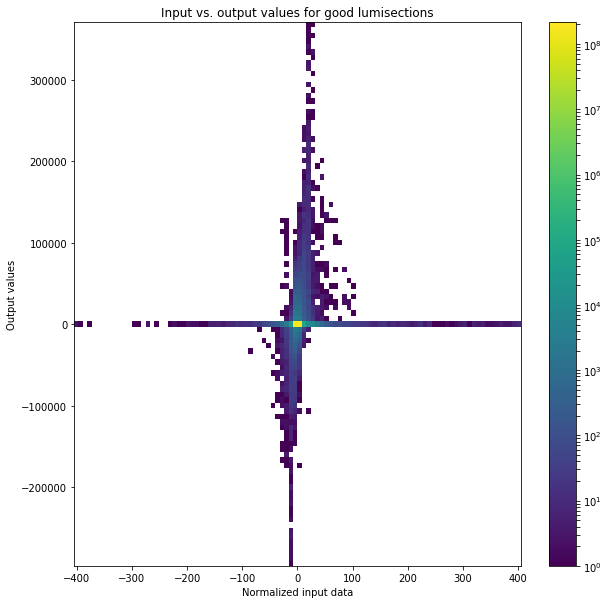

In [28]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.hist2d(normalized_data[normalized_data['label'] == 0].iloc[:, :2806].values.reshape(-1), 
           ae_pred[y == 0].reshape(-1),
          bins=100, norm=LogNorm())
plt.colorbar()
plt.xlabel("Normalized input data")
plt.ylabel("Output values")
plt.title("Input vs. output values for good lumisections")
plt.show()

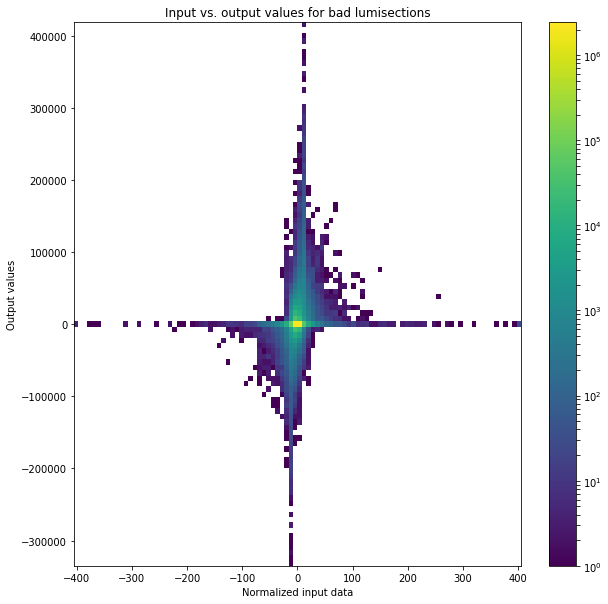

In [29]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.hist2d(normalized_data[normalized_data['label'] == 1].iloc[:, :2806].values.reshape(-1), 
           ae_pred[y == 1].reshape(-1),
          bins=100, norm=LogNorm())
plt.colorbar()
plt.xlabel("Normalized input data")
plt.ylabel("Output values")
plt.title("Input vs. output values for bad lumisections")
plt.show()

## Histograms for arbitrary variable's features

In [30]:
start_legend = 1414
# start_legend = 931
# start_legend = 1575
# start_legend = 1428

var_legend = [{'start': start_legend, 'end': start_legend, 'name': 'Mean'},
              {'start': start_legend+1, 'end': start_legend+1, 'name': 'RMS'},
              {'start': start_legend+2, 'end': start_legend+2, 'name': 'Q1'},
              {'start': start_legend+3, 'end': start_legend+3, 'name': 'Q2'},
              {'start': start_legend+4, 'end': start_legend+4, 'name': 'Q3'},
              {'start': start_legend+5, 'end': start_legend+5, 'name': 'Q4'},
              {'start': start_legend+6, 'end': start_legend+6, 'name': 'Q5'}]

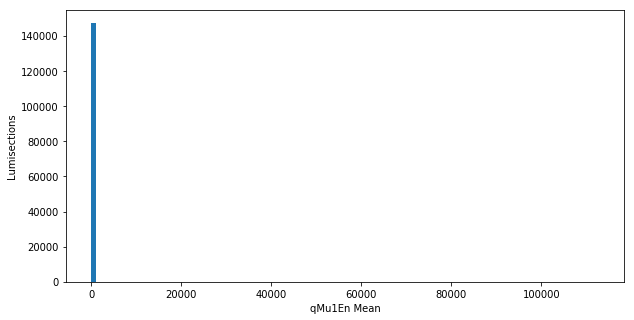

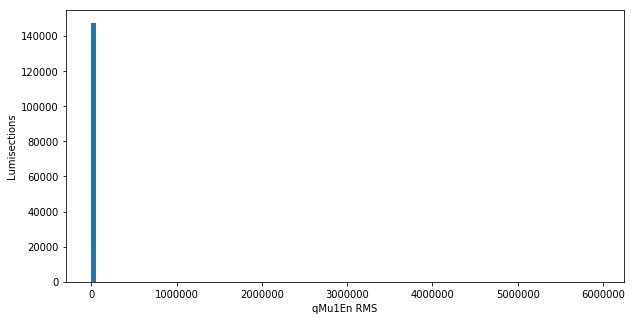

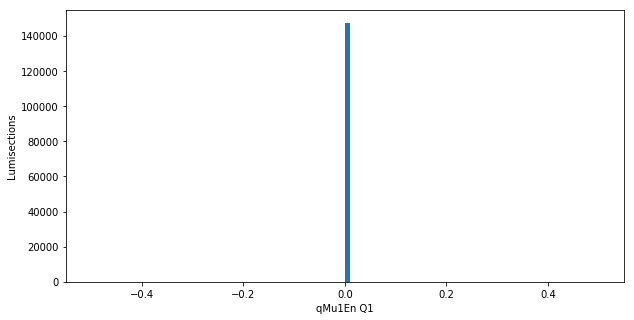

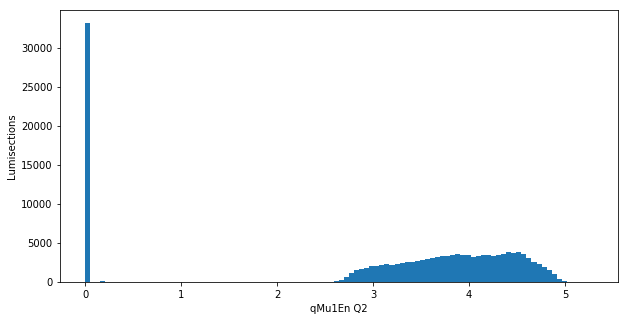

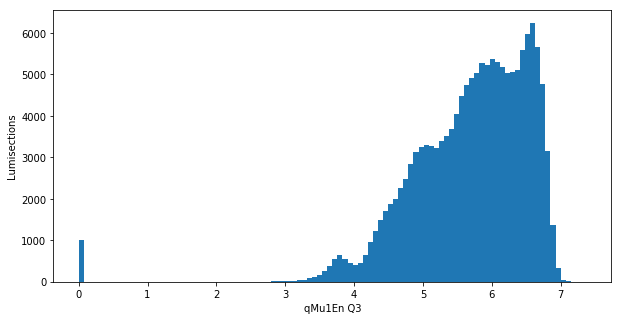

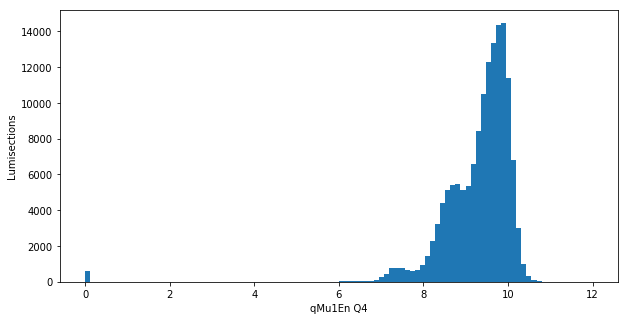

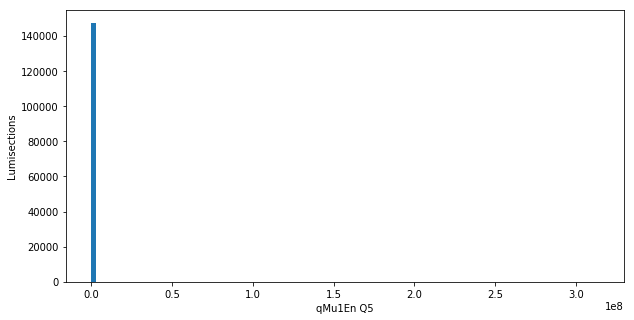

In [31]:
plt.rcParams['figure.figsize'] = [10, 5]
for e in var_legend:
    idx = e['start']
    i, r = divmod(idx, 7)
    plt.hist(data[idx], bins=100)
    plt.ylabel("Lumisections")
    plt.xlabel(feature_names[i] + " " + e['name'])
#     plt.xscale('log')
#     plt.yscale('log')
    plt.show()

In [32]:
idx_1414 = np.where(data[1414+3] == 0)[0]
idx_931 = np.where(data[931+3] == 0)[0]

In [33]:
variance = np.var(normalized_data.iloc[:, :2106], axis=1)

In [34]:
def pred_vs_feature(x_val, y_val, y_class, y_name="", x_name="", selected=[], linear=False,
                    limit=False):
    '''
    Plots two arbitrary values agains each other.
    '''
    df = pd.DataFrame({'y_val': y_val,
                       'x_val': x_val,
                       'y_class': y_class})

    groups = df.groupby('y_class')
    fig, ax = plt.subplots()

    for name, group in groups:
        ax.plot(group.x_val, 
                group.y_val,
                color="r" if name == 1 else "g",
                marker='o',
                ms=2,
                linestyle='',
                alpha=0.5,
                label= "Anomaly" if name == 1 else "Normal")
    
    for s in selected:
        ax.plot(s,
                variance[s],
#                 color="b",
                marker='o',
                ms=2,
                linestyle='',
                alpha=0.5,
                label='Selected')
                 
    ax.legend()
    if not linear:
        ax.set_yscale('log')
    if limit:
        plt.xlim([limit[0], limit[1]])
    plt.grid()
    plt.ylabel(y_name)
    plt.xlabel(x_name)
    plt.show()

/afs/cern.ch/user/t/tkrzyzek/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


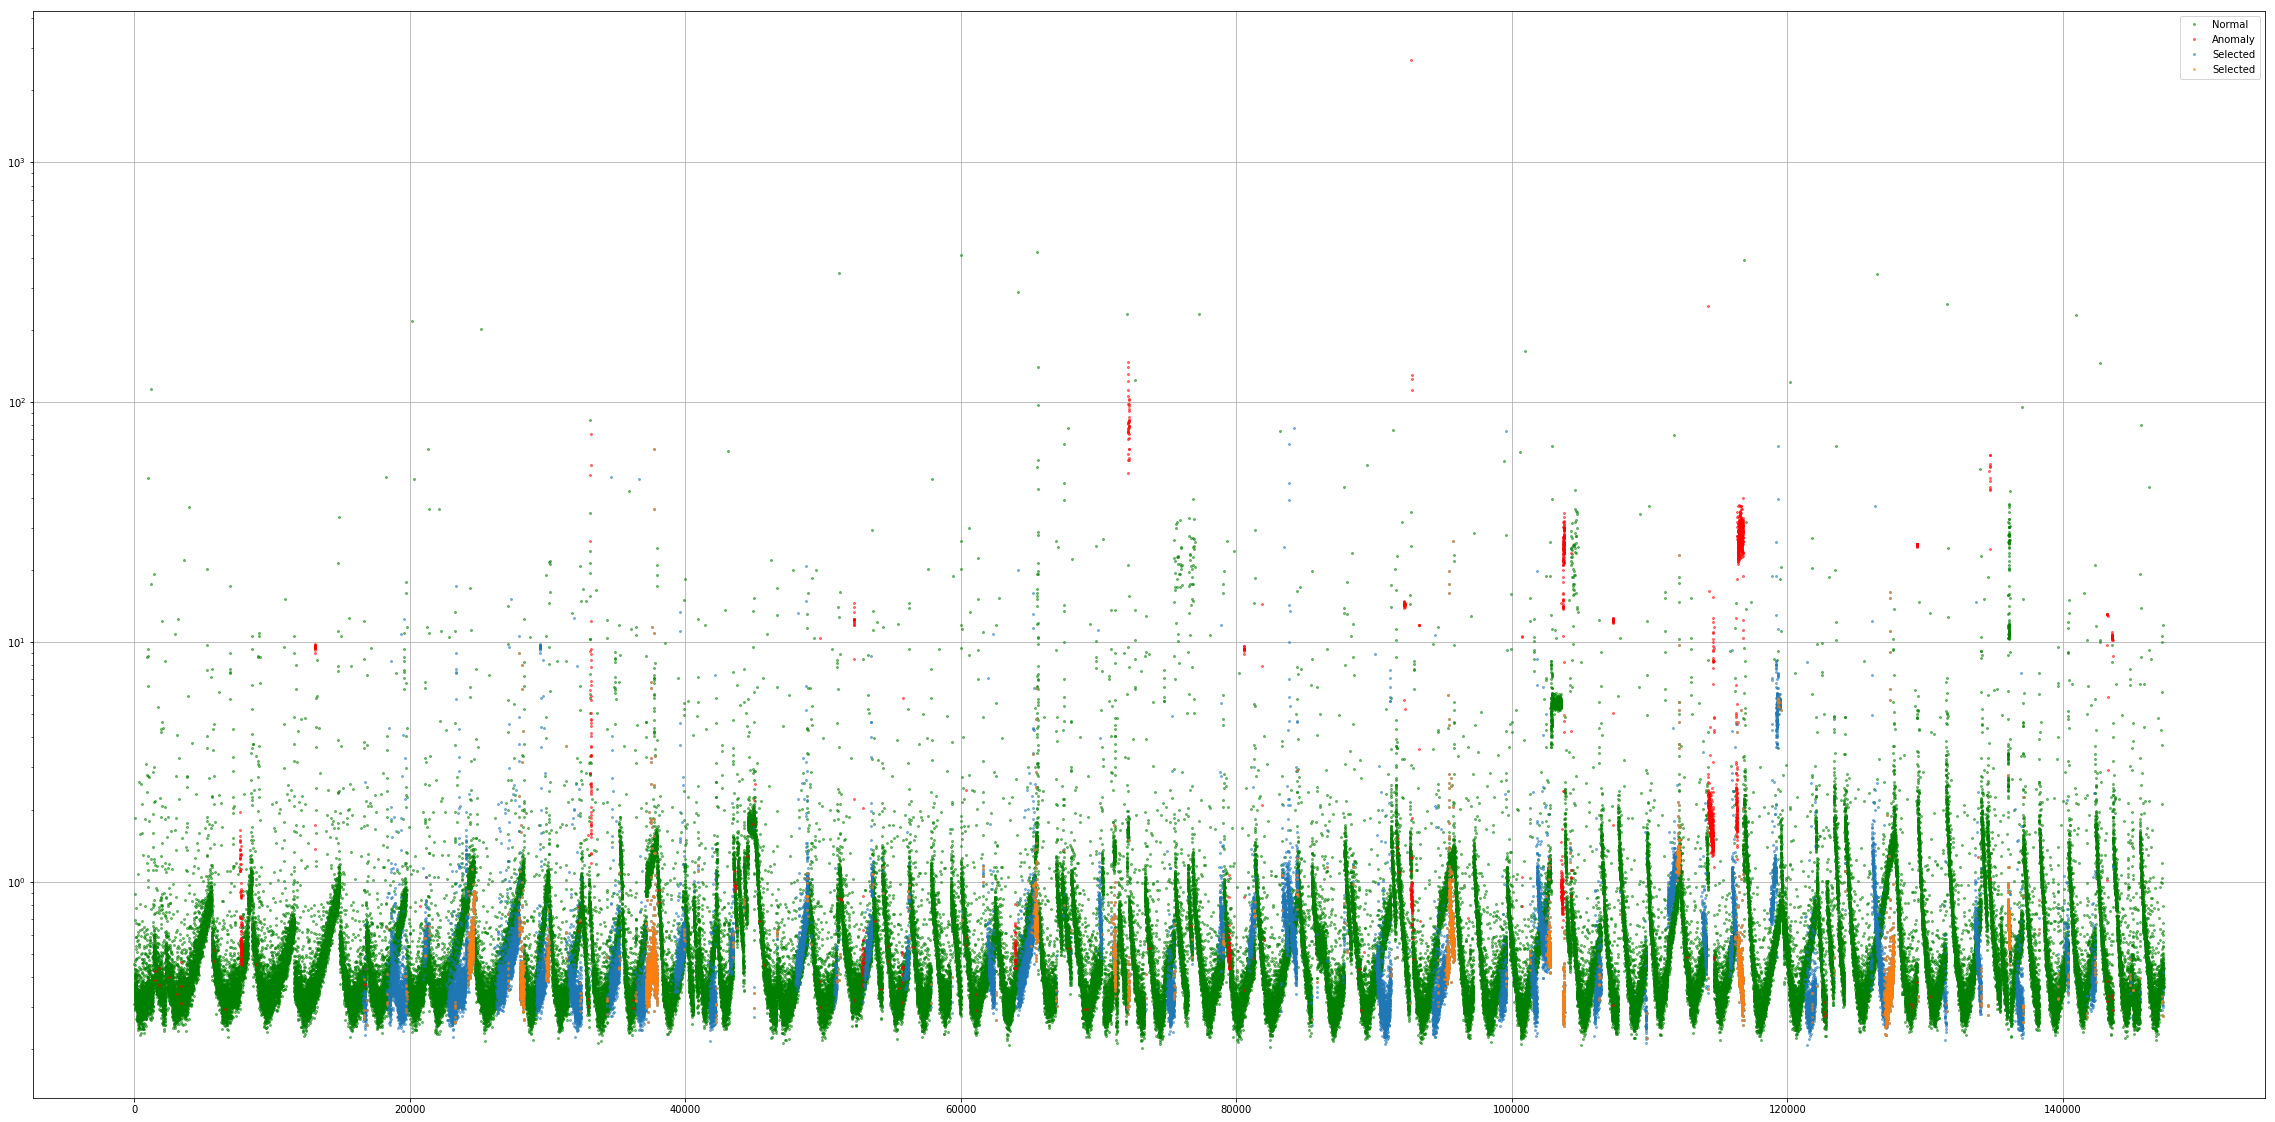

In [35]:
plt.rcParams['figure.figsize'] = [40, 20]
pred_vs_feature(range(len(variance)), variance, data['label'], selected=[idx_1414, idx_931])